In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

class CelebADataset(Dataset):
    def __init__(self, folder_path, image_size=128, transform=None):
        self.folder_path = folder_path
        self.image_size = image_size
        self.transform = transform
        self.image_paths = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [2]:
device = torch.device('cuda')
num_cpus = torch.get_num_threads()

folder_path = "celebA_class_dataset/Smiling_Male_Young"

batch_size=256
dataset = CelebADataset(folder_path=folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpus)

## VAE Model

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space (mean and variance for reparameterization)
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)  # Flatten the features to latent dimension
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),  # Reshape the input to 256x8x8 for the decoder
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 64x64 -> 128x128
            nn.Tanh()  # To map the output to [-1, 1]
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        z = self.decoder_fc(z)
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

## VAE model initialization

In [4]:
latent_dim = 2048
model = VAE(latent_dim=latent_dim).to(device)

In [5]:
def loss_function(reconstructed_x, x, mu, logvar, lambda_kl=1.0):
    BCE = nn.functional.mse_loss(reconstructed_x, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + lambda_kl * KL_divergence

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, optimizer, epochs=10, lambda_kl=1.0):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for batch_idx, data in enumerate(pbar):
                data = data.to(device)
                optimizer.zero_grad()
                reconstructed_x, mu, logvar = model(data)
                loss = loss_function(reconstructed_x, data, mu, logvar, lambda_kl)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (batch_idx + 1))

        avg_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

In [10]:
### Train Model
lambda_kl = 0.4
epochs = 200
train(dataloader, model, optimizer, epochs=epochs, lambda_kl=lambda_kl)

Epoch 1/200: 100%|██████████| 80/80 [00:21<00:00,  3.65batch/s, loss=3.48e+6]


Epoch [1/200], Loss: 13616.0492


Epoch 2/200: 100%|██████████| 80/80 [00:05<00:00, 14.05batch/s, loss=1.93e+6]


Epoch [2/200], Loss: 7553.7633


Epoch 3/200: 100%|██████████| 80/80 [00:05<00:00, 14.33batch/s, loss=1.24e+6]


Epoch [3/200], Loss: 4849.8141


Epoch 4/200: 100%|██████████| 80/80 [00:06<00:00, 13.21batch/s, loss=1.05e+6]


Epoch [4/200], Loss: 4112.5672


Epoch 5/200: 100%|██████████| 80/80 [00:05<00:00, 14.11batch/s, loss=9.43e+5]


Epoch [5/200], Loss: 3684.8496


Epoch 6/200: 100%|██████████| 80/80 [00:06<00:00, 12.93batch/s, loss=8.64e+5]


Epoch [6/200], Loss: 3376.3097


Epoch 7/200: 100%|██████████| 80/80 [00:06<00:00, 12.37batch/s, loss=8.02e+5]


Epoch [7/200], Loss: 3132.7322


Epoch 8/200: 100%|██████████| 80/80 [00:06<00:00, 13.15batch/s, loss=7.6e+5] 


Epoch [8/200], Loss: 2970.5141


Epoch 9/200: 100%|██████████| 80/80 [00:05<00:00, 13.46batch/s, loss=7.23e+5]


Epoch [9/200], Loss: 2823.4791


Epoch 10/200: 100%|██████████| 80/80 [00:06<00:00, 12.76batch/s, loss=6.94e+5]


Epoch [10/200], Loss: 2712.1069


Epoch 11/200: 100%|██████████| 80/80 [00:06<00:00, 12.65batch/s, loss=6.66e+5]


Epoch [11/200], Loss: 2603.1826


Epoch 12/200: 100%|██████████| 80/80 [00:06<00:00, 12.36batch/s, loss=6.44e+5]


Epoch [12/200], Loss: 2518.2517


Epoch 13/200: 100%|██████████| 80/80 [00:06<00:00, 12.51batch/s, loss=6.23e+5]


Epoch [13/200], Loss: 2433.7797


Epoch 14/200: 100%|██████████| 80/80 [00:05<00:00, 13.35batch/s, loss=6.04e+5]


Epoch [14/200], Loss: 2358.3830


Epoch 15/200: 100%|██████████| 80/80 [00:05<00:00, 13.42batch/s, loss=5.85e+5]


Epoch [15/200], Loss: 2286.4474


Epoch 16/200: 100%|██████████| 80/80 [00:06<00:00, 12.81batch/s, loss=5.69e+5]


Epoch [16/200], Loss: 2224.9520


Epoch 17/200: 100%|██████████| 80/80 [00:05<00:00, 13.94batch/s, loss=5.55e+5]


Epoch [17/200], Loss: 2168.9958


Epoch 18/200: 100%|██████████| 80/80 [00:06<00:00, 12.71batch/s, loss=5.42e+5]


Epoch [18/200], Loss: 2118.6308


Epoch 19/200: 100%|██████████| 80/80 [00:05<00:00, 13.47batch/s, loss=5.29e+5]


Epoch [19/200], Loss: 2066.4316


Epoch 20/200: 100%|██████████| 80/80 [00:05<00:00, 13.52batch/s, loss=5.17e+5]


Epoch [20/200], Loss: 2019.6162


Epoch 21/200: 100%|██████████| 80/80 [00:06<00:00, 11.70batch/s, loss=5.07e+5]


Epoch [21/200], Loss: 1979.5931


Epoch 22/200: 100%|██████████| 80/80 [00:05<00:00, 13.47batch/s, loss=4.95e+5]


Epoch [22/200], Loss: 1936.1190


Epoch 23/200: 100%|██████████| 80/80 [00:05<00:00, 13.81batch/s, loss=4.86e+5]


Epoch [23/200], Loss: 1901.1185


Epoch 24/200: 100%|██████████| 80/80 [00:05<00:00, 14.07batch/s, loss=4.76e+5]


Epoch [24/200], Loss: 1861.3165


Epoch 25/200: 100%|██████████| 80/80 [00:06<00:00, 13.14batch/s, loss=4.7e+5] 


Epoch [25/200], Loss: 1835.5759


Epoch 26/200: 100%|██████████| 80/80 [00:06<00:00, 12.91batch/s, loss=4.6e+5] 


Epoch [26/200], Loss: 1798.5103


Epoch 27/200: 100%|██████████| 80/80 [00:05<00:00, 13.73batch/s, loss=4.53e+5]


Epoch [27/200], Loss: 1770.5028


Epoch 28/200: 100%|██████████| 80/80 [00:06<00:00, 12.99batch/s, loss=4.46e+5]


Epoch [28/200], Loss: 1742.8438


Epoch 29/200: 100%|██████████| 80/80 [00:06<00:00, 13.13batch/s, loss=4.4e+5] 


Epoch [29/200], Loss: 1718.1610


Epoch 30/200: 100%|██████████| 80/80 [00:06<00:00, 11.97batch/s, loss=4.33e+5]


Epoch [30/200], Loss: 1691.5453


Epoch 31/200: 100%|██████████| 80/80 [00:05<00:00, 14.29batch/s, loss=4.27e+5]


Epoch [31/200], Loss: 1667.1872


Epoch 32/200: 100%|██████████| 80/80 [00:06<00:00, 13.06batch/s, loss=4.2e+5] 


Epoch [32/200], Loss: 1640.1072


Epoch 33/200: 100%|██████████| 80/80 [00:05<00:00, 13.98batch/s, loss=4.14e+5]


Epoch [33/200], Loss: 1619.3354


Epoch 34/200: 100%|██████████| 80/80 [00:06<00:00, 12.14batch/s, loss=4.08e+5]


Epoch [34/200], Loss: 1594.9297


Epoch 35/200: 100%|██████████| 80/80 [00:06<00:00, 12.76batch/s, loss=4.02e+5]


Epoch [35/200], Loss: 1572.5855


Epoch 36/200: 100%|██████████| 80/80 [00:06<00:00, 13.33batch/s, loss=3.96e+5]


Epoch [36/200], Loss: 1546.8032


Epoch 37/200: 100%|██████████| 80/80 [00:06<00:00, 13.07batch/s, loss=3.91e+5]


Epoch [37/200], Loss: 1526.6164


Epoch 38/200: 100%|██████████| 80/80 [00:06<00:00, 12.57batch/s, loss=3.88e+5]


Epoch [38/200], Loss: 1516.3082


Epoch 39/200: 100%|██████████| 80/80 [00:06<00:00, 13.17batch/s, loss=3.82e+5]


Epoch [39/200], Loss: 1490.8278


Epoch 40/200: 100%|██████████| 80/80 [00:06<00:00, 12.86batch/s, loss=3.77e+5]


Epoch [40/200], Loss: 1474.8251


Epoch 41/200: 100%|██████████| 80/80 [00:05<00:00, 13.37batch/s, loss=3.73e+5]


Epoch [41/200], Loss: 1459.1059


Epoch 42/200: 100%|██████████| 80/80 [00:05<00:00, 13.43batch/s, loss=3.69e+5]


Epoch [42/200], Loss: 1441.8523


Epoch 43/200: 100%|██████████| 80/80 [00:05<00:00, 14.21batch/s, loss=3.66e+5]


Epoch [43/200], Loss: 1429.3788


Epoch 44/200: 100%|██████████| 80/80 [00:05<00:00, 13.37batch/s, loss=3.61e+5]


Epoch [44/200], Loss: 1412.2742


Epoch 45/200: 100%|██████████| 80/80 [00:05<00:00, 13.60batch/s, loss=3.58e+5]


Epoch [45/200], Loss: 1399.1049


Epoch 46/200: 100%|██████████| 80/80 [00:06<00:00, 12.90batch/s, loss=3.54e+5]


Epoch [46/200], Loss: 1383.7285


Epoch 47/200: 100%|██████████| 80/80 [00:05<00:00, 13.71batch/s, loss=3.51e+5]


Epoch [47/200], Loss: 1372.9173


Epoch 48/200: 100%|██████████| 80/80 [00:06<00:00, 12.94batch/s, loss=3.49e+5]


Epoch [48/200], Loss: 1362.2347


Epoch 49/200: 100%|██████████| 80/80 [00:05<00:00, 13.87batch/s, loss=3.46e+5]


Epoch [49/200], Loss: 1352.8410


Epoch 50/200: 100%|██████████| 80/80 [00:05<00:00, 14.31batch/s, loss=3.42e+5]


Epoch [50/200], Loss: 1336.6440


Epoch 51/200: 100%|██████████| 80/80 [00:05<00:00, 13.93batch/s, loss=3.4e+5] 


Epoch [51/200], Loss: 1329.7501


Epoch 52/200: 100%|██████████| 80/80 [00:05<00:00, 13.92batch/s, loss=3.37e+5]


Epoch [52/200], Loss: 1316.6054


Epoch 53/200: 100%|██████████| 80/80 [00:05<00:00, 14.15batch/s, loss=3.36e+5]


Epoch [53/200], Loss: 1311.9380


Epoch 54/200: 100%|██████████| 80/80 [00:05<00:00, 13.93batch/s, loss=3.32e+5]


Epoch [54/200], Loss: 1297.3233


Epoch 55/200: 100%|██████████| 80/80 [00:05<00:00, 14.08batch/s, loss=3.3e+5] 


Epoch [55/200], Loss: 1289.5096


Epoch 56/200: 100%|██████████| 80/80 [00:05<00:00, 14.12batch/s, loss=3.28e+5]


Epoch [56/200], Loss: 1282.9244


Epoch 57/200: 100%|██████████| 80/80 [00:06<00:00, 12.95batch/s, loss=3.25e+5]


Epoch [57/200], Loss: 1271.0027


Epoch 58/200: 100%|██████████| 80/80 [00:05<00:00, 13.35batch/s, loss=3.24e+5]


Epoch [58/200], Loss: 1264.5188


Epoch 59/200: 100%|██████████| 80/80 [00:05<00:00, 14.47batch/s, loss=3.21e+5]


Epoch [59/200], Loss: 1253.9084


Epoch 60/200: 100%|██████████| 80/80 [00:05<00:00, 13.38batch/s, loss=3.19e+5]


Epoch [60/200], Loss: 1246.6162


Epoch 61/200: 100%|██████████| 80/80 [00:05<00:00, 13.52batch/s, loss=3.18e+5]


Epoch [61/200], Loss: 1244.5162


Epoch 62/200: 100%|██████████| 80/80 [00:05<00:00, 13.41batch/s, loss=3.15e+5]


Epoch [62/200], Loss: 1231.3009


Epoch 63/200: 100%|██████████| 80/80 [00:05<00:00, 14.13batch/s, loss=3.13e+5]


Epoch [63/200], Loss: 1224.9204


Epoch 64/200: 100%|██████████| 80/80 [00:05<00:00, 14.09batch/s, loss=3.12e+5]


Epoch [64/200], Loss: 1218.3539


Epoch 65/200: 100%|██████████| 80/80 [00:05<00:00, 14.34batch/s, loss=3.1e+5] 


Epoch [65/200], Loss: 1210.9272


Epoch 66/200: 100%|██████████| 80/80 [00:05<00:00, 14.36batch/s, loss=3.08e+5]


Epoch [66/200], Loss: 1204.7233


Epoch 67/200: 100%|██████████| 80/80 [00:05<00:00, 13.49batch/s, loss=3.07e+5]


Epoch [67/200], Loss: 1198.4330


Epoch 68/200: 100%|██████████| 80/80 [00:05<00:00, 14.22batch/s, loss=3.05e+5]


Epoch [68/200], Loss: 1191.1773


Epoch 69/200: 100%|██████████| 80/80 [00:05<00:00, 13.94batch/s, loss=3.03e+5]


Epoch [69/200], Loss: 1185.1260


Epoch 70/200: 100%|██████████| 80/80 [00:05<00:00, 13.77batch/s, loss=3.02e+5]


Epoch [70/200], Loss: 1179.3143


Epoch 71/200: 100%|██████████| 80/80 [00:05<00:00, 14.17batch/s, loss=2.99e+5]


Epoch [71/200], Loss: 1170.2930


Epoch 72/200: 100%|██████████| 80/80 [00:05<00:00, 14.06batch/s, loss=3e+5]   


Epoch [72/200], Loss: 1170.5287


Epoch 73/200: 100%|██████████| 80/80 [00:05<00:00, 14.47batch/s, loss=2.97e+5]


Epoch [73/200], Loss: 1160.8063


Epoch 74/200: 100%|██████████| 80/80 [00:05<00:00, 14.24batch/s, loss=2.97e+5]


Epoch [74/200], Loss: 1160.0860


Epoch 75/200: 100%|██████████| 80/80 [00:05<00:00, 14.64batch/s, loss=2.95e+5]


Epoch [75/200], Loss: 1151.2319


Epoch 76/200: 100%|██████████| 80/80 [00:05<00:00, 14.67batch/s, loss=2.93e+5]


Epoch [76/200], Loss: 1145.3390


Epoch 77/200: 100%|██████████| 80/80 [00:05<00:00, 14.90batch/s, loss=2.92e+5]


Epoch [77/200], Loss: 1142.8529


Epoch 78/200: 100%|██████████| 80/80 [00:05<00:00, 14.03batch/s, loss=2.9e+5] 


Epoch [78/200], Loss: 1133.1370


Epoch 79/200: 100%|██████████| 80/80 [00:05<00:00, 14.49batch/s, loss=2.89e+5]


Epoch [79/200], Loss: 1130.1060


Epoch 80/200: 100%|██████████| 80/80 [00:05<00:00, 14.46batch/s, loss=2.88e+5]


Epoch [80/200], Loss: 1124.2399


Epoch 81/200: 100%|██████████| 80/80 [00:05<00:00, 14.56batch/s, loss=2.87e+5]


Epoch [81/200], Loss: 1121.1703


Epoch 82/200: 100%|██████████| 80/80 [00:05<00:00, 13.82batch/s, loss=2.86e+5]


Epoch [82/200], Loss: 1116.8999


Epoch 83/200: 100%|██████████| 80/80 [00:06<00:00, 13.24batch/s, loss=2.85e+5]


Epoch [83/200], Loss: 1113.0790


Epoch 84/200: 100%|██████████| 80/80 [00:05<00:00, 14.30batch/s, loss=2.83e+5]


Epoch [84/200], Loss: 1105.1133


Epoch 85/200: 100%|██████████| 80/80 [00:05<00:00, 13.99batch/s, loss=2.82e+5]


Epoch [85/200], Loss: 1101.1488


Epoch 86/200: 100%|██████████| 80/80 [00:05<00:00, 14.63batch/s, loss=2.82e+5]


Epoch [86/200], Loss: 1101.4583


Epoch 87/200: 100%|██████████| 80/80 [00:05<00:00, 14.84batch/s, loss=2.8e+5] 


Epoch [87/200], Loss: 1092.2854


Epoch 88/200: 100%|██████████| 80/80 [00:05<00:00, 14.37batch/s, loss=2.79e+5]


Epoch [88/200], Loss: 1090.5728


Epoch 89/200: 100%|██████████| 80/80 [00:05<00:00, 14.15batch/s, loss=2.79e+5]


Epoch [89/200], Loss: 1090.4418


Epoch 90/200: 100%|██████████| 80/80 [00:05<00:00, 14.73batch/s, loss=2.77e+5]


Epoch [90/200], Loss: 1082.9747


Epoch 91/200: 100%|██████████| 80/80 [00:05<00:00, 14.82batch/s, loss=2.76e+5]


Epoch [91/200], Loss: 1077.0305


Epoch 92/200: 100%|██████████| 80/80 [00:05<00:00, 14.38batch/s, loss=2.75e+5]


Epoch [92/200], Loss: 1076.2410


Epoch 93/200: 100%|██████████| 80/80 [00:05<00:00, 14.01batch/s, loss=2.74e+5]


Epoch [93/200], Loss: 1069.4849


Epoch 94/200: 100%|██████████| 80/80 [00:05<00:00, 13.87batch/s, loss=2.73e+5]


Epoch [94/200], Loss: 1067.9724


Epoch 95/200: 100%|██████████| 80/80 [00:05<00:00, 14.41batch/s, loss=2.72e+5]


Epoch [95/200], Loss: 1063.4184


Epoch 96/200: 100%|██████████| 80/80 [00:05<00:00, 14.50batch/s, loss=2.71e+5]


Epoch [96/200], Loss: 1058.5423


Epoch 97/200: 100%|██████████| 80/80 [00:05<00:00, 13.74batch/s, loss=2.71e+5]


Epoch [97/200], Loss: 1057.1815


Epoch 98/200: 100%|██████████| 80/80 [00:05<00:00, 14.06batch/s, loss=2.69e+5]


Epoch [98/200], Loss: 1052.8202


Epoch 99/200: 100%|██████████| 80/80 [00:05<00:00, 13.74batch/s, loss=2.69e+5]


Epoch [99/200], Loss: 1053.0955


Epoch 100/200: 100%|██████████| 80/80 [00:05<00:00, 14.35batch/s, loss=2.68e+5]


Epoch [100/200], Loss: 1046.3799


Epoch 101/200: 100%|██████████| 80/80 [00:05<00:00, 14.41batch/s, loss=2.67e+5]


Epoch [101/200], Loss: 1042.9158


Epoch 102/200: 100%|██████████| 80/80 [00:05<00:00, 14.58batch/s, loss=2.66e+5]


Epoch [102/200], Loss: 1039.6109


Epoch 103/200: 100%|██████████| 80/80 [00:05<00:00, 14.03batch/s, loss=2.65e+5]


Epoch [103/200], Loss: 1035.4170


Epoch 104/200: 100%|██████████| 80/80 [00:05<00:00, 13.52batch/s, loss=2.65e+5]


Epoch [104/200], Loss: 1034.4294


Epoch 105/200: 100%|██████████| 80/80 [00:05<00:00, 14.03batch/s, loss=2.64e+5]


Epoch [105/200], Loss: 1030.9220


Epoch 106/200: 100%|██████████| 80/80 [00:05<00:00, 14.35batch/s, loss=2.63e+5]


Epoch [106/200], Loss: 1026.9322


Epoch 107/200: 100%|██████████| 80/80 [00:05<00:00, 14.57batch/s, loss=2.63e+5]


Epoch [107/200], Loss: 1026.5208


Epoch 108/200: 100%|██████████| 80/80 [00:05<00:00, 13.60batch/s, loss=2.61e+5]


Epoch [108/200], Loss: 1020.3680


Epoch 109/200: 100%|██████████| 80/80 [00:05<00:00, 14.93batch/s, loss=2.61e+5]


Epoch [109/200], Loss: 1018.7246


Epoch 110/200: 100%|██████████| 80/80 [00:05<00:00, 14.48batch/s, loss=2.6e+5] 


Epoch [110/200], Loss: 1016.4967


Epoch 111/200: 100%|██████████| 80/80 [00:05<00:00, 14.48batch/s, loss=2.59e+5]


Epoch [111/200], Loss: 1013.0215


Epoch 112/200: 100%|██████████| 80/80 [00:05<00:00, 15.15batch/s, loss=2.58e+5]


Epoch [112/200], Loss: 1007.9923


Epoch 113/200: 100%|██████████| 80/80 [00:05<00:00, 13.75batch/s, loss=2.58e+5]


Epoch [113/200], Loss: 1007.4512


Epoch 114/200: 100%|██████████| 80/80 [00:05<00:00, 14.40batch/s, loss=2.57e+5]


Epoch [114/200], Loss: 1004.7560


Epoch 115/200: 100%|██████████| 80/80 [00:05<00:00, 14.25batch/s, loss=2.56e+5]


Epoch [115/200], Loss: 1001.0064


Epoch 116/200: 100%|██████████| 80/80 [00:05<00:00, 14.39batch/s, loss=2.56e+5]


Epoch [116/200], Loss: 1000.9393


Epoch 117/200: 100%|██████████| 80/80 [00:05<00:00, 14.31batch/s, loss=2.55e+5]


Epoch [117/200], Loss: 995.9664


Epoch 118/200: 100%|██████████| 80/80 [00:05<00:00, 14.33batch/s, loss=2.54e+5]


Epoch [118/200], Loss: 991.7517


Epoch 119/200: 100%|██████████| 80/80 [00:05<00:00, 15.07batch/s, loss=2.54e+5]


Epoch [119/200], Loss: 992.7825


Epoch 120/200: 100%|██████████| 80/80 [00:05<00:00, 14.02batch/s, loss=2.53e+5]


Epoch [120/200], Loss: 990.4584


Epoch 121/200: 100%|██████████| 80/80 [00:05<00:00, 13.92batch/s, loss=2.52e+5]


Epoch [121/200], Loss: 985.2077


Epoch 122/200: 100%|██████████| 80/80 [00:05<00:00, 14.08batch/s, loss=2.51e+5]


Epoch [122/200], Loss: 982.1214


Epoch 123/200: 100%|██████████| 80/80 [00:05<00:00, 14.42batch/s, loss=2.53e+5]


Epoch [123/200], Loss: 987.1826


Epoch 124/200: 100%|██████████| 80/80 [00:05<00:00, 14.85batch/s, loss=2.51e+5]


Epoch [124/200], Loss: 980.9713


Epoch 125/200: 100%|██████████| 80/80 [00:05<00:00, 14.95batch/s, loss=2.5e+5] 


Epoch [125/200], Loss: 975.5288


Epoch 126/200: 100%|██████████| 80/80 [00:06<00:00, 13.22batch/s, loss=2.49e+5]


Epoch [126/200], Loss: 972.9323


Epoch 127/200: 100%|██████████| 80/80 [00:06<00:00, 13.02batch/s, loss=2.48e+5]


Epoch [127/200], Loss: 969.6129


Epoch 128/200: 100%|██████████| 80/80 [00:05<00:00, 14.55batch/s, loss=2.48e+5]


Epoch [128/200], Loss: 970.3367


Epoch 129/200: 100%|██████████| 80/80 [00:05<00:00, 14.39batch/s, loss=2.47e+5]


Epoch [129/200], Loss: 967.1509


Epoch 130/200: 100%|██████████| 80/80 [00:05<00:00, 14.46batch/s, loss=2.47e+5]


Epoch [130/200], Loss: 965.2767


Epoch 131/200: 100%|██████████| 80/80 [00:05<00:00, 15.00batch/s, loss=2.47e+5]


Epoch [131/200], Loss: 966.8736


Epoch 132/200: 100%|██████████| 80/80 [00:05<00:00, 14.42batch/s, loss=2.45e+5]


Epoch [132/200], Loss: 958.5671


Epoch 133/200: 100%|██████████| 80/80 [00:05<00:00, 14.69batch/s, loss=2.47e+5]


Epoch [133/200], Loss: 964.4348


Epoch 134/200: 100%|██████████| 80/80 [00:05<00:00, 14.19batch/s, loss=2.45e+5]


Epoch [134/200], Loss: 956.4054


Epoch 135/200: 100%|██████████| 80/80 [00:05<00:00, 14.60batch/s, loss=2.44e+5]


Epoch [135/200], Loss: 954.4724


Epoch 136/200: 100%|██████████| 80/80 [00:05<00:00, 14.50batch/s, loss=2.43e+5]


Epoch [136/200], Loss: 951.1712


Epoch 137/200: 100%|██████████| 80/80 [00:05<00:00, 14.91batch/s, loss=2.43e+5]


Epoch [137/200], Loss: 951.2933


Epoch 138/200: 100%|██████████| 80/80 [00:05<00:00, 14.49batch/s, loss=2.43e+5]


Epoch [138/200], Loss: 948.7186


Epoch 139/200: 100%|██████████| 80/80 [00:05<00:00, 14.43batch/s, loss=2.42e+5]


Epoch [139/200], Loss: 946.1709


Epoch 140/200: 100%|██████████| 80/80 [00:05<00:00, 13.69batch/s, loss=2.42e+5]


Epoch [140/200], Loss: 946.7951


Epoch 141/200: 100%|██████████| 80/80 [00:05<00:00, 13.93batch/s, loss=2.42e+5]


Epoch [141/200], Loss: 943.9366


Epoch 142/200: 100%|██████████| 80/80 [00:05<00:00, 14.86batch/s, loss=2.41e+5]


Epoch [142/200], Loss: 941.1319


Epoch 143/200: 100%|██████████| 80/80 [00:05<00:00, 14.23batch/s, loss=2.4e+5] 


Epoch [143/200], Loss: 938.4678


Epoch 144/200: 100%|██████████| 80/80 [00:05<00:00, 14.35batch/s, loss=2.4e+5] 


Epoch [144/200], Loss: 939.2494


Epoch 145/200: 100%|██████████| 80/80 [00:05<00:00, 14.42batch/s, loss=2.4e+5] 


Epoch [145/200], Loss: 938.0761


Epoch 146/200: 100%|██████████| 80/80 [00:05<00:00, 14.82batch/s, loss=2.38e+5]


Epoch [146/200], Loss: 931.9092


Epoch 147/200: 100%|██████████| 80/80 [00:05<00:00, 14.54batch/s, loss=2.39e+5]


Epoch [147/200], Loss: 932.8428


Epoch 148/200: 100%|██████████| 80/80 [00:05<00:00, 13.86batch/s, loss=2.39e+5]


Epoch [148/200], Loss: 932.5871


Epoch 149/200: 100%|██████████| 80/80 [00:05<00:00, 13.74batch/s, loss=2.37e+5]


Epoch [149/200], Loss: 926.6727


Epoch 150/200: 100%|██████████| 80/80 [00:05<00:00, 14.18batch/s, loss=2.37e+5]


Epoch [150/200], Loss: 925.1820


Epoch 151/200: 100%|██████████| 80/80 [00:05<00:00, 14.16batch/s, loss=2.37e+5]


Epoch [151/200], Loss: 926.1524


Epoch 152/200: 100%|██████████| 80/80 [00:05<00:00, 14.92batch/s, loss=2.36e+5]


Epoch [152/200], Loss: 922.7521


Epoch 153/200: 100%|██████████| 80/80 [00:05<00:00, 13.78batch/s, loss=2.36e+5]


Epoch [153/200], Loss: 920.5563


Epoch 154/200: 100%|██████████| 80/80 [00:05<00:00, 14.93batch/s, loss=2.36e+5]


Epoch [154/200], Loss: 920.4199


Epoch 155/200: 100%|██████████| 80/80 [00:05<00:00, 14.86batch/s, loss=2.35e+5]


Epoch [155/200], Loss: 916.7766


Epoch 156/200: 100%|██████████| 80/80 [00:05<00:00, 14.63batch/s, loss=2.35e+5]


Epoch [156/200], Loss: 917.2449


Epoch 157/200: 100%|██████████| 80/80 [00:05<00:00, 13.53batch/s, loss=2.34e+5]


Epoch [157/200], Loss: 914.3651


Epoch 158/200: 100%|██████████| 80/80 [00:05<00:00, 14.43batch/s, loss=2.34e+5]


Epoch [158/200], Loss: 913.2612


Epoch 159/200: 100%|██████████| 80/80 [00:05<00:00, 14.54batch/s, loss=2.34e+5]


Epoch [159/200], Loss: 912.8280


Epoch 160/200: 100%|██████████| 80/80 [00:05<00:00, 14.26batch/s, loss=2.33e+5]


Epoch [160/200], Loss: 909.3912


Epoch 161/200: 100%|██████████| 80/80 [00:05<00:00, 14.26batch/s, loss=2.33e+5]


Epoch [161/200], Loss: 908.6463


Epoch 162/200: 100%|██████████| 80/80 [00:05<00:00, 14.76batch/s, loss=2.32e+5]


Epoch [162/200], Loss: 908.1852


Epoch 163/200: 100%|██████████| 80/80 [00:05<00:00, 14.10batch/s, loss=2.32e+5]


Epoch [163/200], Loss: 906.6788


Epoch 164/200: 100%|██████████| 80/80 [00:05<00:00, 14.13batch/s, loss=2.32e+5]


Epoch [164/200], Loss: 904.7035


Epoch 165/200: 100%|██████████| 80/80 [00:05<00:00, 14.80batch/s, loss=2.31e+5]


Epoch [165/200], Loss: 901.6075


Epoch 166/200: 100%|██████████| 80/80 [00:05<00:00, 14.34batch/s, loss=2.31e+5]


Epoch [166/200], Loss: 902.0119


Epoch 167/200: 100%|██████████| 80/80 [00:05<00:00, 13.77batch/s, loss=2.31e+5]


Epoch [167/200], Loss: 901.8056


Epoch 168/200: 100%|██████████| 80/80 [00:05<00:00, 14.41batch/s, loss=2.29e+5]


Epoch [168/200], Loss: 896.3160


Epoch 169/200: 100%|██████████| 80/80 [00:05<00:00, 14.42batch/s, loss=2.3e+5] 


Epoch [169/200], Loss: 897.7919


Epoch 170/200: 100%|██████████| 80/80 [00:05<00:00, 14.44batch/s, loss=2.29e+5]


Epoch [170/200], Loss: 895.9242


Epoch 171/200: 100%|██████████| 80/80 [00:05<00:00, 14.06batch/s, loss=2.29e+5]


Epoch [171/200], Loss: 894.2227


Epoch 172/200: 100%|██████████| 80/80 [00:05<00:00, 14.85batch/s, loss=2.29e+5]


Epoch [172/200], Loss: 895.1335


Epoch 173/200: 100%|██████████| 80/80 [00:05<00:00, 14.32batch/s, loss=2.28e+5]


Epoch [173/200], Loss: 891.6394


Epoch 174/200: 100%|██████████| 80/80 [00:05<00:00, 14.85batch/s, loss=2.27e+5]


Epoch [174/200], Loss: 888.7835


Epoch 175/200: 100%|██████████| 80/80 [00:05<00:00, 13.84batch/s, loss=2.27e+5]


Epoch [175/200], Loss: 887.1813


Epoch 176/200: 100%|██████████| 80/80 [00:05<00:00, 14.46batch/s, loss=2.27e+5]


Epoch [176/200], Loss: 886.3460


Epoch 177/200: 100%|██████████| 80/80 [00:05<00:00, 15.18batch/s, loss=2.26e+5]


Epoch [177/200], Loss: 885.0754


Epoch 178/200: 100%|██████████| 80/80 [00:05<00:00, 14.90batch/s, loss=2.27e+5]


Epoch [178/200], Loss: 885.5310


Epoch 179/200: 100%|██████████| 80/80 [00:05<00:00, 15.48batch/s, loss=2.27e+5]


Epoch [179/200], Loss: 885.1918


Epoch 180/200: 100%|██████████| 80/80 [00:05<00:00, 14.48batch/s, loss=2.26e+5]


Epoch [180/200], Loss: 881.5576


Epoch 181/200: 100%|██████████| 80/80 [00:05<00:00, 14.81batch/s, loss=2.25e+5]


Epoch [181/200], Loss: 879.6764


Epoch 182/200: 100%|██████████| 80/80 [00:05<00:00, 13.77batch/s, loss=2.25e+5]


Epoch [182/200], Loss: 878.8475


Epoch 183/200: 100%|██████████| 80/80 [00:05<00:00, 13.42batch/s, loss=2.25e+5]


Epoch [183/200], Loss: 878.8750


Epoch 184/200: 100%|██████████| 80/80 [00:05<00:00, 14.76batch/s, loss=2.24e+5]


Epoch [184/200], Loss: 874.7386


Epoch 185/200: 100%|██████████| 80/80 [00:05<00:00, 14.54batch/s, loss=2.24e+5]


Epoch [185/200], Loss: 875.2228


Epoch 186/200: 100%|██████████| 80/80 [00:05<00:00, 14.47batch/s, loss=2.24e+5]


Epoch [186/200], Loss: 874.1487


Epoch 187/200: 100%|██████████| 80/80 [00:05<00:00, 14.45batch/s, loss=2.23e+5]


Epoch [187/200], Loss: 872.1135


Epoch 188/200: 100%|██████████| 80/80 [00:05<00:00, 14.38batch/s, loss=2.23e+5]


Epoch [188/200], Loss: 871.2194


Epoch 189/200: 100%|██████████| 80/80 [00:05<00:00, 13.53batch/s, loss=2.24e+5]


Epoch [189/200], Loss: 874.1180


Epoch 190/200: 100%|██████████| 80/80 [00:05<00:00, 14.62batch/s, loss=2.22e+5]


Epoch [190/200], Loss: 868.4981


Epoch 191/200: 100%|██████████| 80/80 [00:05<00:00, 14.15batch/s, loss=2.22e+5]


Epoch [191/200], Loss: 867.3042


Epoch 192/200: 100%|██████████| 80/80 [00:05<00:00, 14.05batch/s, loss=2.22e+5]


Epoch [192/200], Loss: 866.2545


Epoch 193/200: 100%|██████████| 80/80 [00:05<00:00, 14.38batch/s, loss=2.22e+5]


Epoch [193/200], Loss: 865.7862


Epoch 194/200: 100%|██████████| 80/80 [00:05<00:00, 14.99batch/s, loss=2.21e+5]


Epoch [194/200], Loss: 862.8244


Epoch 195/200: 100%|██████████| 80/80 [00:05<00:00, 14.57batch/s, loss=2.21e+5]


Epoch [195/200], Loss: 864.8224


Epoch 196/200: 100%|██████████| 80/80 [00:05<00:00, 13.94batch/s, loss=2.21e+5]


Epoch [196/200], Loss: 863.7925


Epoch 197/200: 100%|██████████| 80/80 [00:05<00:00, 14.99batch/s, loss=2.2e+5] 


Epoch [197/200], Loss: 859.9074


Epoch 198/200: 100%|██████████| 80/80 [00:05<00:00, 13.63batch/s, loss=2.2e+5]


Epoch [198/200], Loss: 859.5800


Epoch 199/200: 100%|██████████| 80/80 [00:05<00:00, 14.40batch/s, loss=2.2e+5] 


Epoch [199/200], Loss: 859.4182


Epoch 200/200: 100%|██████████| 80/80 [00:05<00:00, 13.79batch/s, loss=2.2e+5] 

Epoch [200/200], Loss: 859.7370


In [9]:
def get_latent_representation(index):
    image_tensor = dataset[index]
    img = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        mu, logvar = model.encode(img)
    return mu, logvar

def decode_latent_representation(mu, logvar):
    with torch.no_grad():
        latent_rep = model.reparameterize(mu, logvar)
        reconstructed_image = model.decode(latent_rep)
    return reconstructed_image

def visualize_images(original_image_tensor, reconstructed_image_tensor):

    # Process the reconstructed image
    reconstructed_image = reconstructed_image_tensor.cpu().squeeze(0).detach().numpy()
    reconstructed_image = reconstructed_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    reconstructed_image = (reconstructed_image + 1) / 2  # Rescale to [0, 1]

    # Process the original image
    image = original_image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C)
    image = (image + 1) / 2  # Rescale to [0, 1]

    # Plot the original and reconstructed images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()


### Training Dataset Reconstructions by the VAE model

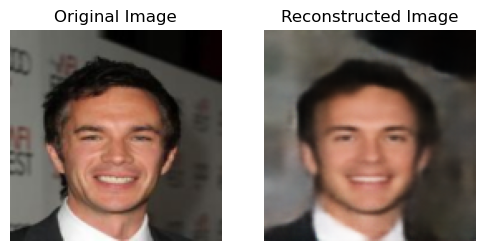

In [23]:
i = 343
visualize_images(dataset[i], decode_latent_representation(*get_latent_representation(i)))

In [26]:
# Save only the weights (state_dict)
torch.save(model.state_dict(), f'model_weights_{latent_dim}.pth')

## Update model using saved weights

In [6]:
model.load_state_dict(torch.load(f'model_weights_{latent_dim}.pth', weights_only=True))

<All keys matched successfully>

### Save reconstructions of training images

In [24]:
output_dir1 = f"reconstructed_images_{latent_dim}_dim_celeba"
os.makedirs(output_dir1, exist_ok=True)

folder_path = "celebA_class_dataset/Smiling_Male_Young"

batch_size=256
dataset = CelebADataset(folder_path=folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

# Set the model to evaluation mode
model.eval()

# Transformation to convert tensor to image
to_pil_image = transforms.ToPILImage()

# Iterate over the training set with tqdm for progress bar
with torch.no_grad():  # Disable gradient computation for inference
    for i, images in tqdm(enumerate(dataloader), total=len(dataloader)):
        images = images.to(device)  # Move images to device (GPU/CPU)

        reconstructed_images, _, _ = model(images)

        for j in range(reconstructed_images.size(0)):  # Iterate over batch size
            # Process reconstructed image
            reconstructed_image = (reconstructed_images[j] + 1) / 2  # Normalize the reconstructed image
            reconstructed_image_pil = to_pil_image(reconstructed_image.cpu())  # Convert to PIL image

            # Save reconstructed image
            reconstructed_image_pil.save(f"{output_dir1}/reconstructed_{i * batch_size + j}.jpg", format='JPEG')


100%|██████████| 80/80 [00:34<00:00,  2.31it/s]


### Save reconstructions of GAN images

In [40]:
folder_path = "gan_outputs"
batch_size=64
dataset = CelebADataset(folder_path=folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)

# Create an output directory if it doesn't exist
output_dir2 = f"reconstructed_images_{latent_dim}_dim_gan"
os.makedirs(output_dir2, exist_ok=True)

# Iterate over the training set with tqdm for progress bar
with torch.no_grad():  # Disable gradient computation for inference
    for i, images in tqdm(enumerate(dataloader), total=len(dataloader)):
        images = images.to(device)  # Move images to device (GPU/CPU)

        reconstructed_images, _, _ = model(images)

        for j in range(reconstructed_images.size(0)):  # Iterate over batch size
            # Process reconstructed image
            reconstructed_image = (reconstructed_images[j] + 1) / 2  # Normalize the reconstructed image
            reconstructed_image_pil = to_pil_image(reconstructed_image.cpu())  # Convert to PIL image

            # Save reconstructed image
            reconstructed_image_pil.save(f"{output_dir2}/reconstructed_{i * batch_size + j}.png")


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


## GAN Images Reconstructions by the VAE model

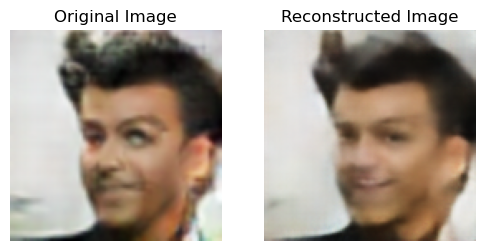

In [48]:
i = 579
visualize_images(dataset[i], decode_latent_representation(*get_latent_representation(i)))

## FID Calculations

In [47]:
import fid_helper

celeba = "celebA_class_dataset/Smiling_Male_Young"
fid_helper.compute_fid(celeba, output_dir1)

print('\n')

fid_helper.compute_fid(celeba, output_dir2);

Loading images from celebA_class_dataset/Smiling_Male_Young: 100%|██████████| 20473/20473 [00:29<00:00, 698.98it/s]


20472 Images


Loading images from reconstructed_images_2048_dim_celeba: 100%|██████████| 20472/20472 [00:15<00:00, 1313.39it/s]


20472 Images


Processing generated images: 100%|██████████| 1280/1280 [00:19<00:00, 66.47it/s]


FID Score: 42.561927795410156




Loading images from celebA_class_dataset/Smiling_Male_Young: 100%|██████████| 20473/20473 [00:25<00:00, 818.53it/s]


20472 Images


Loading images from reconstructed_images_2048_dim_gan: 100%|██████████| 1000/1000 [00:01<00:00, 835.38it/s]


1000 Images


Processing generated images: 100%|██████████| 63/63 [00:01<00:00, 42.36it/s]


FID Score: 118.50237274169922
